### Import Required Packages

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

### Constant Variables

In [169]:
DATASET_PATH = './Data/dataset.csv'
COLUMNS_TO_DROP = [
    'Timestamp',
    'Affiliations',
    'Platforms Used',
    'Social Media User?'
]

### Data Cleaning

#### Load the dataset

In [170]:
df = pd.read_csv(DATASET_PATH)

#### Rename the columns for data analysis

In [171]:

df.rename(columns={'1. What is your age?': 'Age', '2. Gender': 'Gender', '3. Relationship Status': 'Relationship Status',
                   '4. Occupation Status': 'Occupation',
                   '5. What type of organizations are you affiliated with?': 'Affiliations',
                   '6. Do you use social media?': 'Social Media User?',
                   '7. What social media platforms do you commonly use?': 'Platforms Used',
                   '8. What is the average time you spend on social media every day?': 'Hours Per Day',
                   '9. How often do you find yourself using Social media without a specific purpose?': 'ADHD Q1',
                   '10. How often do you get distracted by Social media when you are busy doing something?': 'ADHD Q2',
                   "11. Do you feel restless if you haven't used Social media in a while?": 'Anxiety Q1',
                   '12. On a scale of 1 to 5, how easily distracted are you?': 'ADHD Q3',
                   '13. On a scale of 1 to 5, how much are you bothered by worries?': 'Anxiety Q2',
                   '14. Do you find it difficult to concentrate on things?': 'ADHD Q4',
                   '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?': 'Self Esteem Q1',
                   '16. Following the previous question, how do you feel about these comparisons, generally speaking?': 'Self Esteem Q2',
                   '17. How often do you look to seek validation from features of social media?': 'Self Esteem Q3',
                   '18. How often do you feel depressed or down?': 'Depression Q1',
                   '19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?': 'Depression Q2',
                   '20. On a scale of 1 to 5, how often do you face issues regarding sleep?': 'Depression Q3'}, inplace=True)
df.drop(COLUMNS_TO_DROP, inplace=True, axis=1)

#### Unify the gender category and convert age type

In [172]:

df.replace('Non-binary', 'Non-Binary', inplace=True)
df.replace('Nonbinary ', 'Non-Binary', inplace=True)
df.replace('NB', 'Non-Binary', inplace=True)
df.replace('Non binary ', 'Non-Binary', inplace=True)

df['Age'] = df['Age'].astype('int64')

#### Calculate ADHD and Depression Score

In [173]:

df.loc[df['Self Esteem Q2'] == 1, 'Self Esteem Q2'] = 5
df.loc[df['Self Esteem Q2'] == 2, 'Self Esteem Q2'] = 4
df.loc[df['Self Esteem Q2'] == 3, 'Self Esteem Q2'] = 3
df.loc[df['Self Esteem Q2'] == 4, 'Self Esteem Q2'] = 2
df.loc[df['Self Esteem Q2'] == 5, 'Self Esteem Q2'] = 1

ADHD = ['ADHD Q1', 'ADHD Q2', 'ADHD Q3', 'ADHD Q4']
df['ADHD Score'] = df[ADHD].sum(axis=1)

Anxiety = ['Anxiety Q1', 'Anxiety Q2']
df['Anxiety Score'] = df[Anxiety].sum(axis=1)

SelfEsteem = ['Self Esteem Q1', 'Self Esteem Q2', 'Self Esteem Q3']
df['Self Esteem Score'] = df[SelfEsteem].sum(axis=1)

Depression = ['Depression Q1', 'Depression Q2', 'Depression Q3']
df['Depression Score'] = df[Depression].sum(axis=1)

Total = ['ADHD Score', 'Anxiety Score',
         'Self Esteem Score', 'Depression Score']
df['Total Score'] = df[Total].sum(axis=1)

# Deleting question columns and timestamp columns as they are no longer used
df.drop(columns=ADHD + Anxiety + SelfEsteem + Depression, inplace=True)

#### Convert usage time into integer

In [174]:

df.loc[df['Hours Per Day'] == 'More than 5 hours', 'Hours Per Day'] = 5.5
df.loc[df['Hours Per Day'] == 'Between 2 and 3 hours', 'Hours Per Day'] = 2.5
df.loc[df['Hours Per Day'] == 'Between 3 and 4 hours', 'Hours Per Day'] = 3.5
df.loc[df['Hours Per Day'] == 'Between 1 and 2 hours', 'Hours Per Day'] = 1.5
df.loc[df['Hours Per Day'] == 'Between 4 and 5 hours', 'Hours Per Day'] = 4.5
df.loc[df['Hours Per Day'] == 'Less than an Hour', 'Hours Per Day'] = 0.5

# since the person who answered 91 also answered that they are college student, we assumed that this was a typo
df.loc[df['Age'] == 91, 'Age'] = 19

#### Map Categorical Values to Numerical Values

In [175]:
def handle_nominal_data(df: pd.DataFrame, featrue: str):
    dummy_df = pd.get_dummies(df[featrue], drop_first=True)

    # Convert True/False values in dummy_df to 0/1
    dummy_df = dummy_df.astype(int)

    # Concatenate dummy variables with original DataFrame
    df = pd.concat([df, dummy_df], axis=1)

    # Drop the original 'Relationship Status' column
    df.drop(columns=[featrue], inplace=True)

    return df

In [176]:
df = handle_nominal_data(df, 'Relationship Status')
df = handle_nominal_data(df, 'Occupation')
df = handle_nominal_data(df, 'Gender')

### Final Dataset

In [177]:
df.head()

,Age,Hours Per Day,ADHD Score,Anxiety Score,Self Esteem Score,Depression Score,Total Score,In a relationship,Married,Single,Salaried Worker,School Student,University Student,Male,Non-Binary,There are others???,Trans,unsure
0,21,2.5,18,4,7,14,43,1,0,0,0,0,1,1,0,0,0,0
1,21,5.5,15,7,7,14,43,0,0,1,0,0,1,0,0,0,0,0
2,21,3.5,11,6,7,11,35,0,0,1,0,0,1,0,0,0,0,0
3,21,5.5,12,6,8,9,35,0,0,1,0,0,1,0,0,0,0,0
4,21,2.5,17,9,9,9,44,0,0,1,0,0,1,0,0,0,0,0


### Data Statistics

#### Data Distribution

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'ADHD Score'}>,
        <Axes: title={'center': 'Anxiety Score'}>,
        <Axes: title={'center': 'Self Esteem Score'}>],
       [<Axes: title={'center': 'Depression Score'}>,
        <Axes: title={'center': 'Total Score'}>,
        <Axes: title={'center': 'In a relationship'}>,
        <Axes: title={'center': 'Married'}>],
       [<Axes: title={'center': 'Single'}>,
        <Axes: title={'center': 'Salaried Worker'}>,
        <Axes: title={'center': 'School Student'}>,
        <Axes: title={'center': 'University Student'}>],
       [<Axes: title={'center': 'Male'}>,
        <Axes: title={'center': 'Non-Binary'}>,
        <Axes: title={'center': 'There are others???'}>,
        <Axes: title={'center': 'Trans'}>],
       [<Axes: title={'center': 'unsure '}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

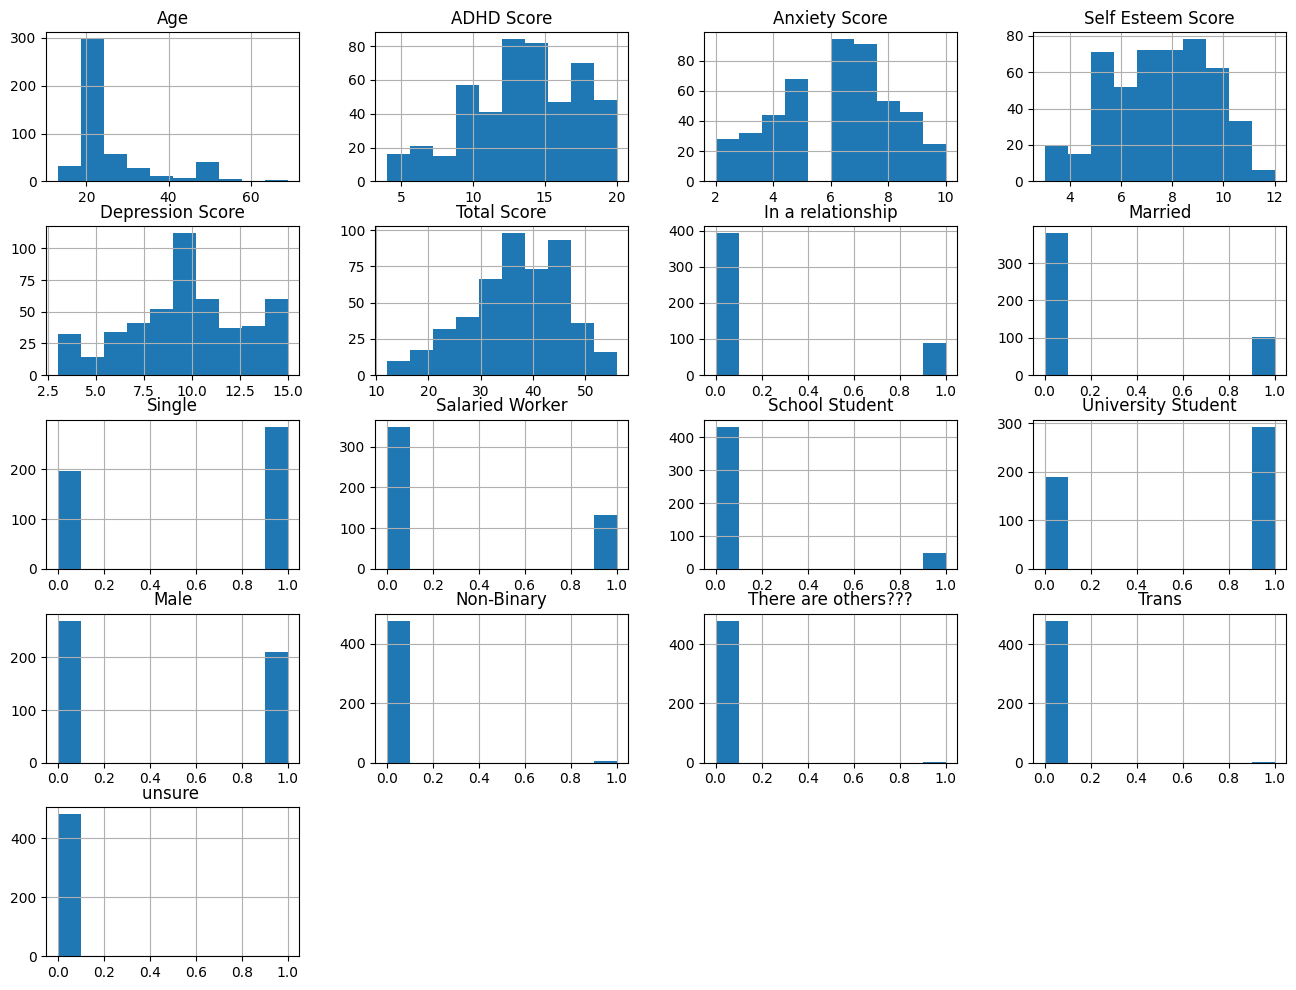

In [181]:
df.hist(figsize=(16, 12))

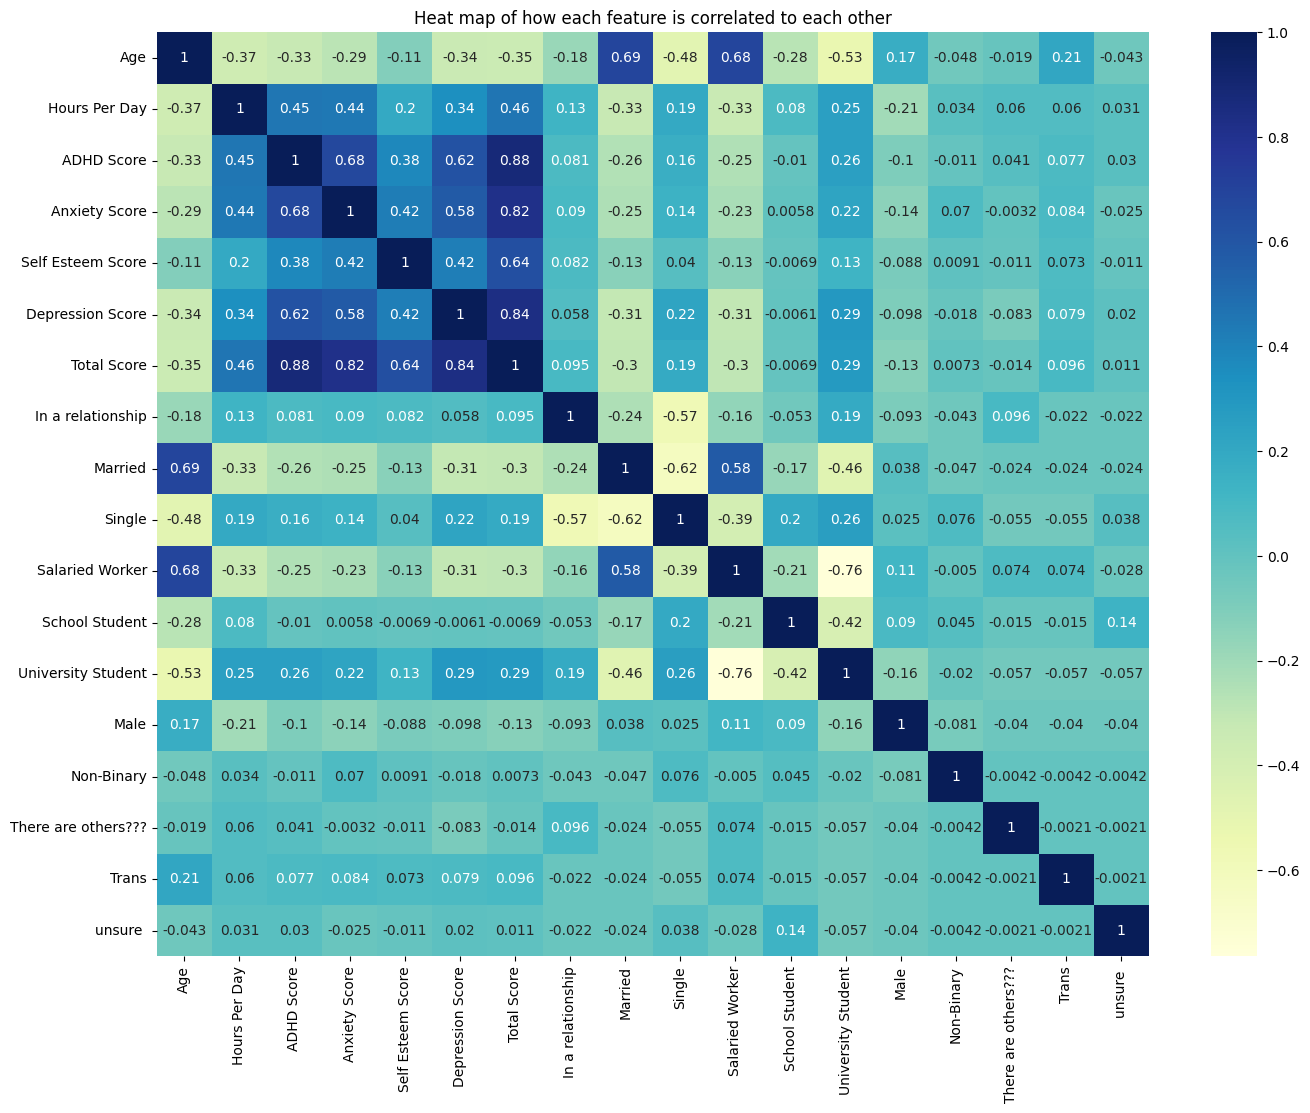

In [184]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr, annot=True, cmap="YlGnBu", ax=ax)
plt.title('Heat map of how each feature is correlated to each other')

plt.show()